In [1]:
# =========================
# Cell 1: Imports and setup
# =========================
# Requirements: numpy, pandas, matplotlib, seaborn, scipy

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats

# Plot style and numeric print precision
sns.set(context="talk", style="whitegrid", palette="deep")
np.set_printoptions(suppress=True, floatmode="fixed", precision=4)

# Ensure output directories exist before any savefig
os.makedirs("figures", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Versions for reproducibility (optional)
import sys
print("Python:", sys.version.split()[0])
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("seaborn:", sns.__version__)
import scipy
print("scipy:", scipy.__version__)


Python: 3.11.5
numpy: 1.24.4
pandas: 2.2.2
matplotlib: 3.10.5
seaborn: 0.12.2
scipy: 1.11.1


In [3]:
# =======================================
# Cell 2: Raw experimental data (physics)
# =======================================
# Water-cooling experiment sampled every 2 minutes for 30 minutes
t_min = np.array([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0,
                  16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0])
T_C = np.array([55.0, 51.9, 46.8, 44.0, 40.8, 38.4, 36.1, 34.3,
                32.6, 31.2, 29.7, 28.6, 27.9, 27.0, 26.5, 26.8])
Tamb = 25.0  # measured ambient temperature (°C)

df = pd.DataFrame({"t_min": t_min, "T_C": T_C})
df["DeltaT_C"] = df["T_C"] - Tamb
df.to_csv("data/water_cooling_data.csv", index=False)  # save raw data
df.head()


,t_min,T_C,DeltaT_C
0,0.0,55.0,30.0
1,2.0,51.9,26.9
2,4.0,46.8,21.8
3,6.0,44.0,19.0
4,8.0,40.8,15.8


In [4]:
# ==========================================
# Cell 3: Helper functions (models & stats)
# ==========================================
def linearized_fit_known_Tinf(t, T, Tinf):
    """
    Linearized fit of ln(ΔT) = b + m t with ΔT = T - Tinf.
    Returns predictions in T-space and a delta-method CI for τ = -1/m.
    """
    dT = T - Tinf
    mask = dT > 0
    t_lin = t[mask]
    ln_dT = np.log(dT[mask])

    lin = stats.linregress(t_lin, ln_dT)
    m, b = lin.slope, lin.intercept
    tau = -1.0 / m
    DeltaT0_hat = math.exp(b)

    # Project back to temperature space for diagnostics
    T_hat = Tinf + DeltaT0_hat * np.exp(m * t)
    res = T - T_hat

    SSE = np.sum(res**2)
    SST = np.sum((T - T.mean())**2)
    R2 = 1 - SSE / SST
    # df ~ n_fit - 2 (slope & intercept in the linearized space)
    RMSE = math.sqrt(SSE / (len(t_lin) - 2))

    # Delta-method CI for tau using t critical value
    n = len(t_lin)
    tcrit = stats.t.ppf(0.975, df=n-2)
    se_m = lin.stderr
    se_tau = se_m / (m**2)
    tau_ci = (tau - tcrit*se_tau, tau + tcrit*se_tau)

    return {
        "m": m, "b": b, "tau": tau, "tau_ci": tau_ci, "se_tau": se_tau,
        "DeltaT0_hat": DeltaT0_hat, "T_hat": T_hat,
        "R2": R2, "RMSE": RMSE, "residuals": res,
        "t_lin": t_lin, "ln_dT": ln_dT
    }


def nlls_exponential_fit(t, T):
    """
    Nonlinear least squares of T(t) = Tinf + A * exp(-t/tau).
    Returns t-based CIs with df = n - p.
    """
    def model(tt, Tinf, A, tau):
        return Tinf + A * np.exp(-tt / tau)

    # Conservative initialization
    Tinf0 = float(np.min(T) - 0.5)
    A0 = float(np.max(T) - Tinf0)
    tau0 = max(1.0, (t[-1] - t[0]) / 3.0)
    bounds = ([0.0, 0.0, 0.1], [60.0, 200.0, 200.0])

    popt, pcov = curve_fit(model, t, T, p0=[Tinf0, A0, tau0],
                           bounds=bounds, maxfev=20000)
    Tinf_hat, A_hat, tau_hat = popt
    perr = np.sqrt(np.diag(pcov))
    Tinf_se, A_se, tau_se = perr

    n, p = len(t), len(popt)
    tcrit = stats.t.ppf(0.975, df=n - p)
    Tinf_ci = (Tinf_hat - tcrit*Tinf_se, Tinf_hat + tcrit*Tinf_se)
    tau_ci  = (tau_hat  - tcrit*tau_se,  tau_hat  + tcrit*tau_se)

    T_hat = model(t, *popt)
    res = T - T_hat
    SSE = np.sum(res**2)
    SST = np.sum((T - T.mean())**2)
    R2 = 1 - SSE / SST
    RMSE = math.sqrt(SSE / (n - p))

    return {
        "Tinf": Tinf_hat, "A": A_hat, "tau": tau_hat,
        "Tinf_ci": Tinf_ci, "tau_ci": tau_ci, "se_tau": tau_se,
        "T_hat": T_hat, "R2": R2, "RMSE": RMSE, "residuals": res
    }


def ar1_with_intercept_fit(x, dt):
    """
    Fit AR(1) with intercept: x_t = c + phi * x_{t-1} + e_t.
    Map to OU: phi = exp(-k dt), k = -ln(phi)/dt, tau = 1/k.
    Includes delta-method SEs for k and tau.
    """
    y = x[1:]
    Xlag = x[:-1]
    n = len(y)
    X = np.column_stack([np.ones(n), Xlag])

    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    beta = XtX_inv @ (X.T @ y)
    c_hat, phi_hat = float(beta[0]), float(beta[1])

    y_hat = X @ beta
    resid = y - y_hat
    s2 = float((resid @ resid) / (n - 2))
    cov_beta = s2 * XtX_inv
    se_c, se_phi = math.sqrt(cov_beta[0, 0]), math.sqrt(cov_beta[1, 1])

    mu_hat = c_hat / (1.0 - phi_hat)

    # Guard range for log
    phi_hat = min(max(phi_hat, 1e-6), 0.999999)
    k_hat = -math.log(phi_hat) / dt
    tau_hat = 1.0 / k_hat
    half_life = math.log(2.0) / k_hat

    # Delta-method
    var_phi = se_phi**2
    var_k = var_phi / (phi_hat**2 * dt**2)
    se_k = math.sqrt(var_k)
    se_tau = se_k / (k_hat**2)  # since dτ/dk = -1/k^2

    # Discrete innovation stdev and continuous OU diffusion
    sigma_eps = math.sqrt(s2)
    sigma_diff = math.sqrt(2.0 * k_hat * s2 / (1.0 - phi_hat**2))
    sigma_stationary = sigma_diff / math.sqrt(2.0 * k_hat)

    return {
        "c": c_hat, "phi": phi_hat, "se_phi": se_phi, "mu": mu_hat,
        "k": k_hat, "se_k": se_k, "tau": tau_hat, "se_tau": se_tau,
        "half_life": half_life, "sigma_eps": sigma_eps,
        "sigma_diff": sigma_diff, "sigma_stationary": sigma_stationary,
        "residuals": resid, "y_hat": y_hat, "Xlag": Xlag, "y": y
    }


def impulse_response(phi, H):
    """AR(1) impulse response for deviations from the mean: phi^h."""
    h = np.arange(H + 1)
    return h, phi ** h


def simulate_ou(n_steps, dt, k, mu=0.0, sigma=1.0, x0=0.0, seed=42):
    """Exact discrete-time OU simulation equivalent to the continuous-time model."""
    rng = np.random.default_rng(seed)
    x = np.empty(n_steps)
    x[0] = x0
    phi = math.exp(-k * dt)
    var_eps = sigma**2 * (1 - math.exp(-2*k*dt)) / (2*k)
    eps_std = math.sqrt(var_eps)
    for t in range(1, n_steps):
        x[t] = mu + phi * (x[t-1] - mu) + rng.normal(0.0, eps_std)
    return x, phi, eps_std


def acf(x, max_lag):
    """Simple autocorrelation function up to max_lag (biased)."""
    x = np.asarray(x)
    x = x - x.mean()
    denom = np.dot(x, x)
    out = [1.0]
    for k in range(1, max_lag + 1):
        out.append(float(np.dot(x[:-k], x[k:]) / denom))
    return np.array(out)


In [5]:
# ==================================
# Cell 4: Fits (physics and AR(1)/OU)
# ==================================
lin  = linearized_fit_known_Tinf(df["t_min"].to_numpy(), df["T_C"].to_numpy(), Tamb)
nlls = nlls_exponential_fit(df["t_min"].to_numpy(), df["T_C"].to_numpy())

dt = 2.0  # minutes
x = df["DeltaT_C"].to_numpy()
ou = ar1_with_intercept_fit(x, dt)

lin, nlls, ou  # quick glance at results


({'m': -0.10328143249111531,
  'b': 3.5582340096656537,
  'tau': 9.682282438191628,
  'tau_ci': (9.014134113438866, 10.35043076294439),
  'se_tau': 0.3115220401715961,
  'DeltaT0_hat': 35.101154078676046,
  'T_hat': array([60.1012, 53.5504, 48.2222, 43.8884, 40.3633, 37.4961, 35.1640,
         33.2672, 31.7243, 30.4694, 29.4487, 28.6184, 27.9431, 27.3939,
         26.9471, 26.5837]),
  'R2': 0.9721913391513749,
  'RMSE': 1.592367238684591,
  'residuals': array([-5.1012, -1.6504, -1.4222,  0.1116,  0.4367,  0.9039,  0.9360,
          1.0328,  0.8757,  0.7306,  0.2513, -0.0184, -0.0431, -0.3939,
         -0.4471,  0.2163]),
  't_lin': array([ 0.0000,  2.0000,  4.0000,  6.0000,  8.0000, 10.0000, 12.0000,
         14.0000, 16.0000, 18.0000, 20.0000, 22.0000, 24.0000, 26.0000,
         28.0000, 30.0000]),
  'ln_dT': array([3.4012, 3.2921, 3.0819, 2.9444, 2.7600, 2.5953, 2.4069, 2.2300,
         2.0281, 1.8245, 1.5476, 1.2809, 1.0647, 0.6931, 0.4055, 0.5878])},
 {'Tinf': 22.30193705769712,
 

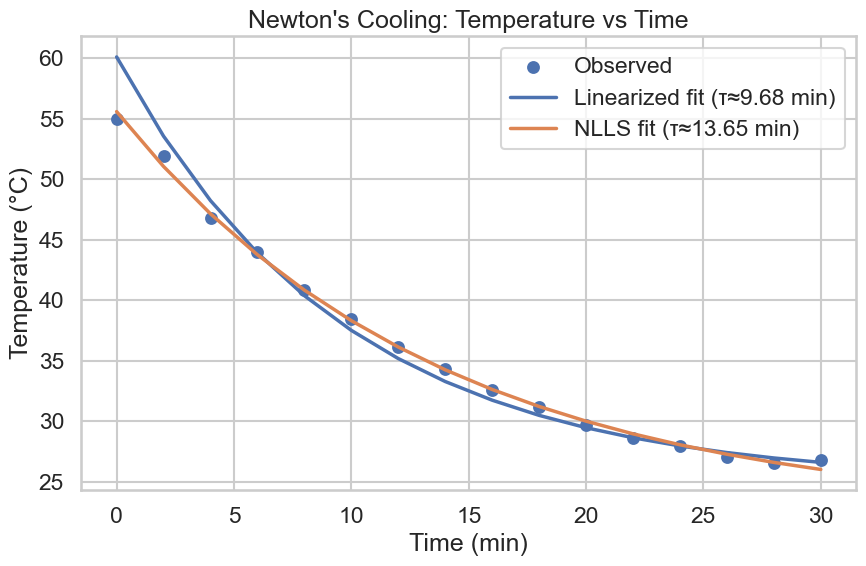

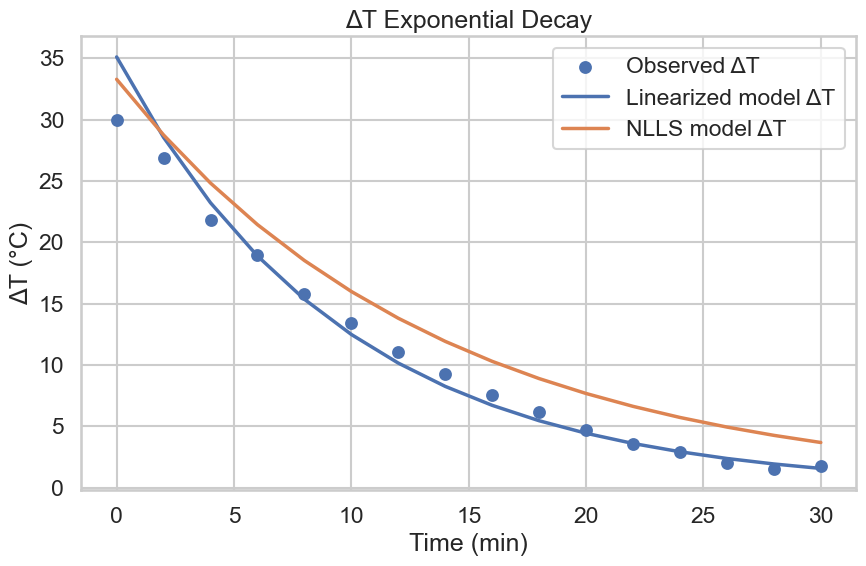

/var/folders/_v/6ktzht8x7s76r67x5mhb0dph0000gn/T/ipykernel_12072/1134254185.py:40: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/_v/6ktzht8x7s76r67x5mhb0dph0000gn/T/ipykernel_12072/1134254185.py:41: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.savefig("figures/fig3_ln_deltaT_vs_time.png", dpi=200)
/Users/jesusg/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


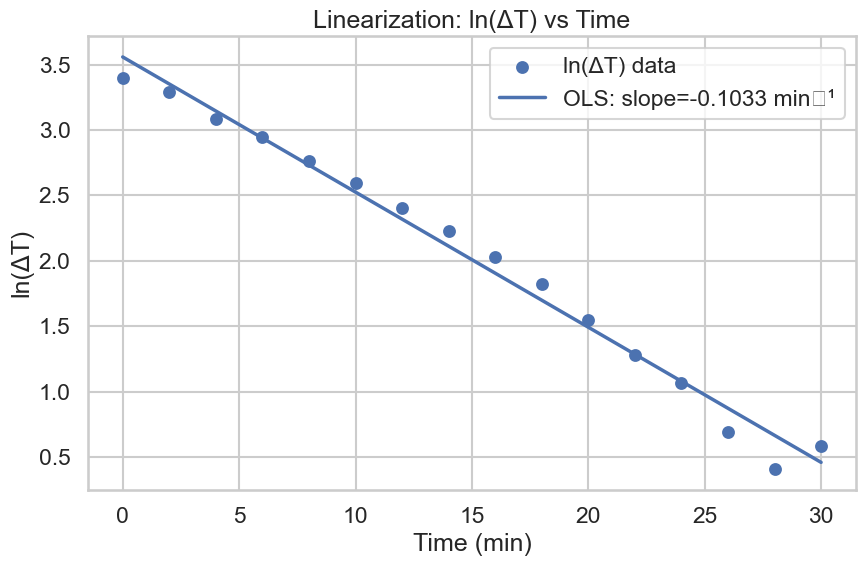

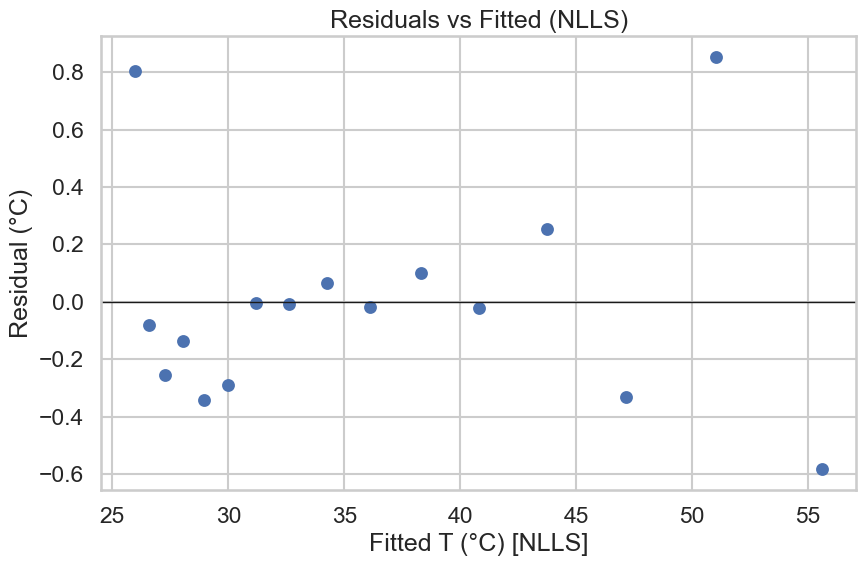

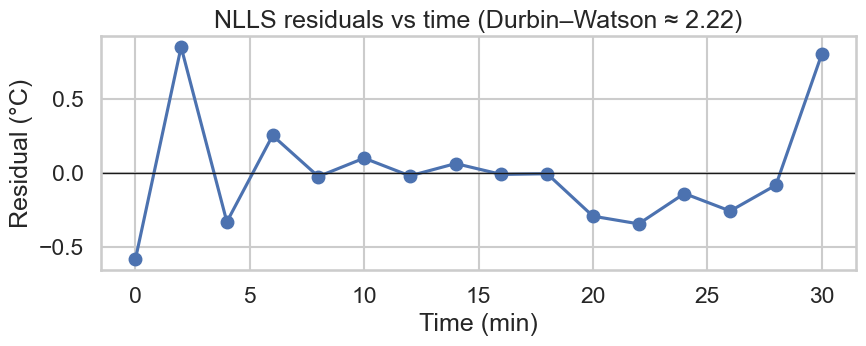

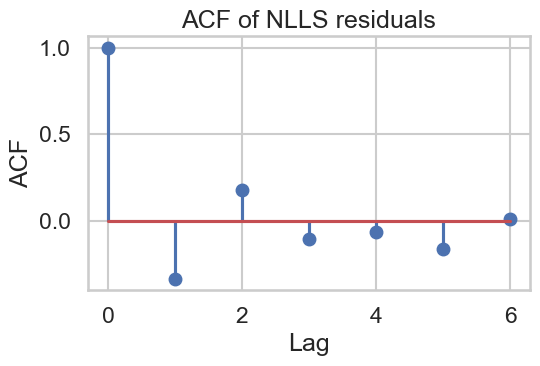

In [11]:
# ==================================
# Cell 5: Figures 1–4 (diagnostics)
# ==================================

# Figure 1: Temperature vs time with both fits
plt.figure(figsize=(9, 6))
plt.scatter(df["t_min"], df["T_C"], s=60, label="Observed")
plt.plot(df["t_min"], lin["T_hat"], lw=2.5, label=f"Linearized fit (τ≈{lin['tau']:.2f} min)")
plt.plot(df["t_min"], nlls["T_hat"], lw=2.5, label=f"NLLS fit (τ≈{nlls['tau']:.2f} min)")
plt.xlabel("Time (min)")
plt.ylabel("Temperature (°C)")
plt.title("Newton's Cooling: Temperature vs Time")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig1_T_vs_time.png", dpi=200)
plt.show()

# Figure 2: ΔT vs time
plt.figure(figsize=(9, 6))
plt.scatter(df["t_min"], df["DeltaT_C"], s=60, label="Observed ΔT")
plt.plot(df["t_min"], (lin["DeltaT0_hat"] * np.exp(lin["m"] * df["t_min"])), lw=2.5, label="Linearized model ΔT")
plt.plot(df["t_min"], (nlls["T_hat"] - nlls["Tinf"]), lw=2.5, label="NLLS model ΔT")
plt.xlabel("Time (min)")
plt.ylabel("ΔT (°C)")
plt.title("ΔT Exponential Decay")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig2_deltaT_vs_time.png", dpi=200)
plt.show()

# Figure 3: Linearization ln(ΔT) vs time
plt.figure(figsize=(9, 6))
plt.scatter(lin["t_lin"], lin["ln_dT"], s=60, label="ln(ΔT) data")
plt.plot(lin["t_lin"], lin["b"] + lin["m"] * lin["t_lin"], lw=2.5,
         label=f"OLS: slope={lin['m']:.4f} min⁻¹")
plt.xlabel("Time (min)")
plt.ylabel("ln(ΔT)")
plt.title("Linearization: ln(ΔT) vs Time")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig3_ln_deltaT_vs_time.png", dpi=200)
plt.show()

# Figure 4: Residuals vs fitted (NLLS)
plt.figure(figsize=(9, 6))
plt.axhline(0, color="k", lw=1)
plt.scatter(nlls["T_hat"], nlls["residuals"], s=60)
plt.xlabel("Fitted T (°C) [NLLS]")
plt.ylabel("Residual (°C)")
plt.title("Residuals vs Fitted (NLLS)")
plt.tight_layout()
plt.savefig("figures/fig4_residuals_nlls.png", dpi=200)
plt.show()

# Optional diagnostics: residuals vs time and ACF
dw = np.sum(np.diff(nlls["residuals"])**2) / np.sum(nlls["residuals"]**2)
acf_vals = acf(nlls["residuals"], max_lag=6)

plt.figure(figsize=(9, 3.8))
plt.plot(df["t_min"], nlls["residuals"], marker="o")
plt.axhline(0, color="k", lw=1)
plt.xlabel("Time (min)"); plt.ylabel("Residual (°C)")
plt.title(f"NLLS residuals vs time (Durbin–Watson ≈ {dw:.2f})")
plt.tight_layout(); plt.savefig("figures/fig4a_residuals_vs_time.png", dpi=200); plt.show()

# ACF stem plot — compatible across Matplotlib versions
lags = np.arange(len(acf_vals))
plt.figure(figsize=(6, 4))
try:
    plt.stem(lags, acf_vals, use_line_collection=True)  # Matplotlib < 3.8
except TypeError:
    plt.stem(lags, acf_vals)  # Matplotlib >= 3.8
plt.xlabel("Lag"); plt.ylabel("ACF")
plt.title("ACF of NLLS residuals")
plt.tight_layout(); plt.savefig("figures/fig4b_acf_residuals.png", dpi=200); plt.show()


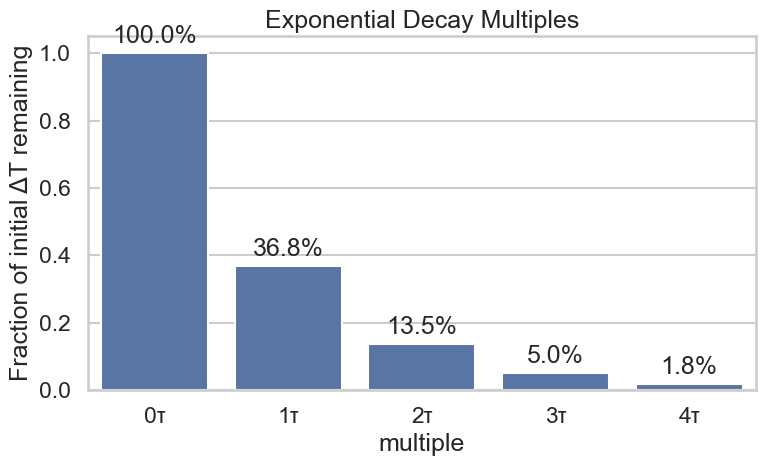

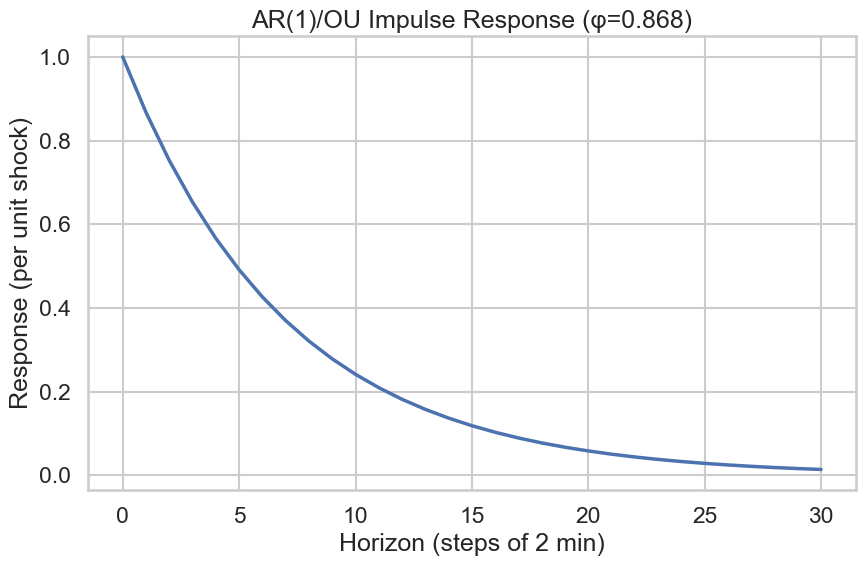

In [12]:
# ======================================
# Cell 6: Figures 5–6 (decay and impulse)
# ======================================

# Figure 5: Fractions remaining at multiples of τ
fractions = np.exp(-np.array([0, 1, 2, 3, 4]))

# Use a DataFrame so seaborn sees a proper pandas Series instead of a raw list
decay_df = pd.DataFrame({
    "multiple": pd.Index([f"{k}τ" for k in range(5)], dtype="object"),
    "fraction": fractions
})

plt.figure(figsize=(8, 5))
sns.barplot(data=decay_df, x="multiple", y="fraction", color="#4C72B0")
plt.ylim(0, 1.05)
for i, val in enumerate(decay_df["fraction"].to_numpy()):
    plt.text(i, val + 0.03, f"{val*100:.1f}%", ha="center")
plt.ylabel("Fraction of initial ΔT remaining")
plt.title("Exponential Decay Multiples")
plt.tight_layout()
plt.savefig("figures/fig5_multiples_of_tau.png", dpi=200)
plt.show()

# Figure 6: AR(1)/OU impulse response
H = 30
h, irf = impulse_response(ou["phi"], H)
plt.figure(figsize=(9, 6))
plt.plot(h, irf, lw=2.5)
plt.xlabel(f"Horizon (steps of {dt:.0f} min)")
plt.ylabel("Response (per unit shock)")
plt.title(f"AR(1)/OU Impulse Response (φ={ou['phi']:.3f})")
plt.tight_layout()
plt.savefig("figures/fig6_irf_phi.png", dpi=200)
plt.show()


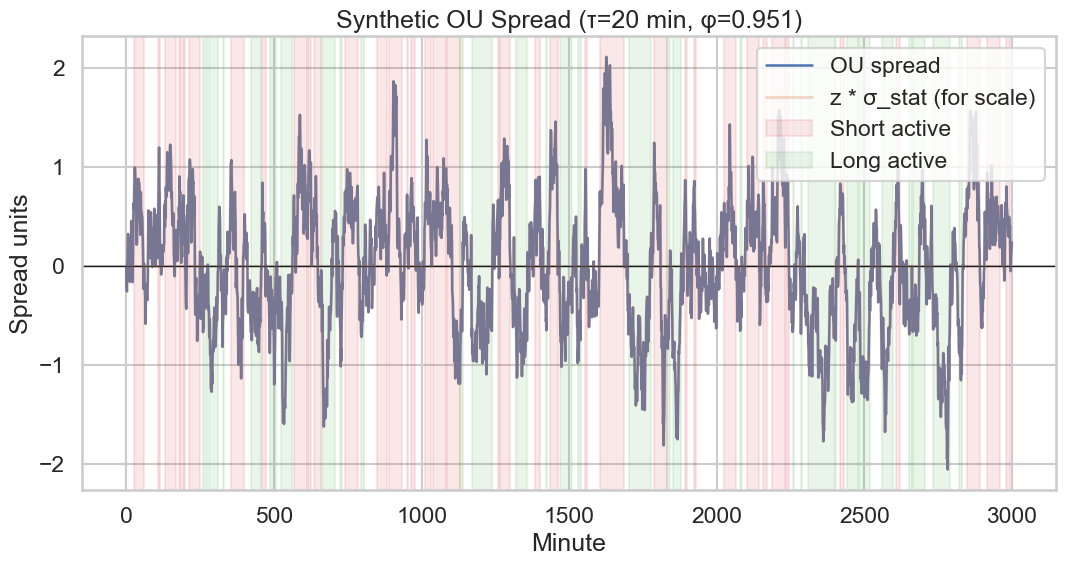

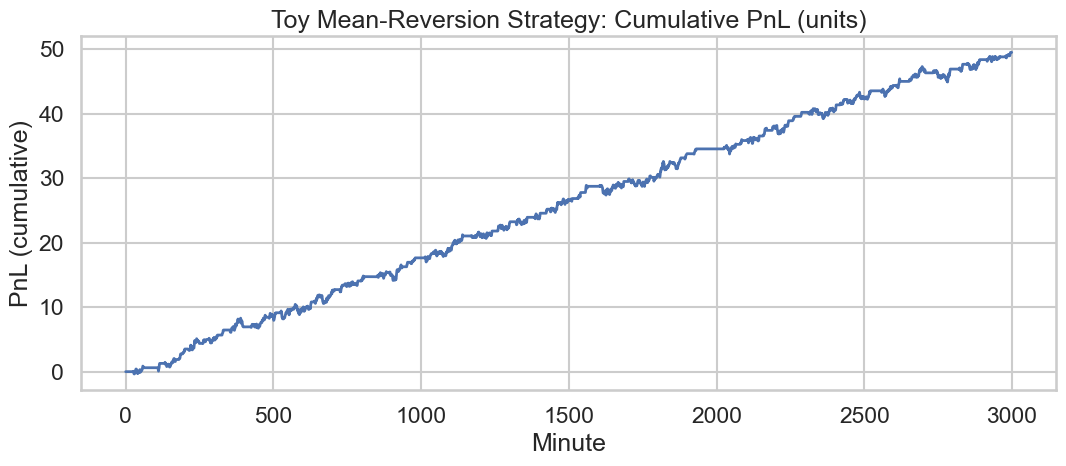

{'turns': 134,
 'trades': 66,
 'win_rate': 0.9848484848484849,
 'pnl_total': 49.47929944456503,
 'pnl_per_step_mean': 0.01649309981485504,
 'pnl_per_step_std': 0.1580781463364759,
 'sharpe_annual': 32.70868064740426,
 'half_life_steps': 15}

In [8]:
# =======================================================
# Cell 7: Synthetic OU and toy mean-reversion strategy
# =======================================================
# Synthetic OU parameters (educational only)
n_steps = 3000       # minutes
dt_synth = 1.0
tau_synth = 20.0
k_synth = 1.0 / tau_synth
mu_synth = 0.0
sigma_synth = 0.20
x0 = 0.0

x_syn, phi_syn, eps_std_syn = simulate_ou(n_steps, dt_synth, k_synth, mu_synth, sigma_synth, x0, seed=123)
sigma_stat_syn = sigma_synth / math.sqrt(2.0 * k_synth)

def simple_reversion_strategy(x, sigma_stationary, entry_z=1.0, exit_z=0.1,
                              max_holds_in_half_lives=3.0, dt=1.0, cost_per_turn=0.0):
    """
    Toy strategy on a mean-reverting spread (units are "spread units").
    - Enter short if z > entry_z, long if z < -entry_z.
    - Exit when |z| < exit_z or after a cap measured in half-lives.
    - Educational PnL: -position * Δx (ignores financing/costs/cointegration details).
    """
    z = x / sigma_stationary
    n = len(x)
    pos = np.zeros(n, dtype=int)
    pnl = np.zeros(n)
    entry_idx = -np.ones(n, dtype=int)

    # Estimate half-life from AR(1) on demeaned x
    fit = ar1_with_intercept_fit(x - np.mean(x), dt)
    half_life_steps = int(max(1, round(fit["half_life"] / dt)))
    max_holds = int(max_holds_in_half_lives * half_life_steps)

    for t in range(1, n):
        # Exit rules
        if pos[t-1] != 0:
            held = t - entry_idx[t-1]
            if abs(z[t]) < exit_z or held >= max_holds:
                pos[t] = 0
                pnl[t] -= cost_per_turn
            else:
                pos[t] = pos[t-1]

        # Entry rules
        if pos[t] == 0:
            if z[t] > entry_z:
                pos[t] = +1; entry_idx[t] = t; pnl[t] -= cost_per_turn
            elif z[t] < -entry_z:
                pos[t] = -1; entry_idx[t] = t; pnl[t] -= cost_per_turn

        # Carry entry index if still in position
        if pos[t] != 0 and entry_idx[t] < 0:
            entry_idx[t] = entry_idx[t-1]

        # Educational PnL: benefit when x mean-reverts
        dx = x[t] - x[t-1]
        pnl[t] += -pos[t-1] * dx

    cum_pnl = np.cumsum(pnl)

    # Simple trade stats
    turns = int(np.sum(np.abs(np.diff(pos)) > 0))
    wins = 0; trades = 0; i = 1
    while i < n:
        if pos[i-1] == 0 and pos[i] != 0:
            sign = pos[i]; j = i+1
            while j < n and pos[j] == sign:
                j += 1
            trade_pnl = cum_pnl[j-1] - cum_pnl[i-1]
            wins += (trade_pnl > 0); trades += 1; i = j
        else:
            i += 1

    ret = pnl
    mu_r = float(np.mean(ret))
    sd_r = float(np.std(ret, ddof=1)) if np.std(ret, ddof=1) > 0 else np.nan
    minutes_per_year = 252 * 390
    sharpe_annual = float(mu_r / sd_r * math.sqrt(minutes_per_year)) if sd_r and sd_r > 0 else np.nan

    stats_out = {
        "turns": turns, "trades": trades,
        "win_rate": (wins / trades) if trades > 0 else np.nan,
        "pnl_total": float(cum_pnl[-1]),
        "pnl_per_step_mean": mu_r, "pnl_per_step_std": sd_r,
        "sharpe_annual": sharpe_annual,
        "half_life_steps": half_life_steps
    }
    return {"pos": pos, "pnl": pnl, "cum_pnl": cum_pnl, "z": z, "stats": stats_out}

strategy = simple_reversion_strategy(x_syn, sigma_stat_syn, entry_z=1.0, exit_z=0.1,
                                     max_holds_in_half_lives=3.0, dt=dt_synth, cost_per_turn=0.0)

# Figure 7: Synthetic OU path with long/short shading
t_idx = np.arange(n_steps)
plt.figure(figsize=(11, 6))
plt.plot(t_idx, x_syn, label="OU spread", lw=1.8)
plt.axhline(0, color="k", lw=1)
plt.plot(t_idx, strategy["z"] * sigma_stat_syn, alpha=0.3, label="z * σ_stat (for scale)")
pos = strategy["pos"]
plt.fill_between(t_idx, 0, 1, where=(pos > 0), color="#D62728", alpha=0.1,
                 transform=plt.gca().get_xaxis_transform(), label="Short active")
plt.fill_between(t_idx, 0, 1, where=(pos < 0), color="#2CA02C", alpha=0.1,
                 transform=plt.gca().get_xaxis_transform(), label="Long active")
plt.title(f"Synthetic OU Spread (τ={tau_synth:.0f} min, φ={phi_syn:.3f})")
plt.xlabel("Minute"); plt.ylabel("Spread units")
plt.legend(loc="upper right"); plt.tight_layout()
plt.savefig("figures/fig7_synth_ou_path.png", dpi=200)
plt.show()

# Figure 8: Strategy cumulative PnL (spread units)
plt.figure(figsize=(11, 5))
plt.plot(strategy["cum_pnl"], lw=2.0, color="#4C72B0")
plt.title("Toy Mean-Reversion Strategy: Cumulative PnL (units)")
plt.xlabel("Minute"); plt.ylabel("PnL (cumulative)")
plt.tight_layout(); plt.savefig("figures/fig8_strategy_cumpnl.png", dpi=200); plt.show()

strategy["stats"]


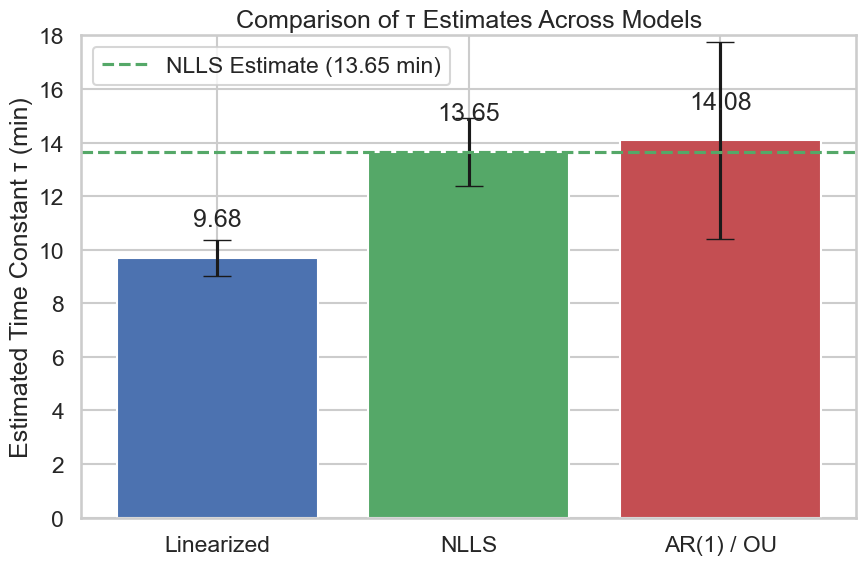

In [9]:
# ============================================
# Cell 8: τ comparison (Figure 9, bar chart)
# ============================================
methods = ['Linearized', 'NLLS', 'AR(1) / OU']
taus = [lin['tau'], nlls['tau'], ou['tau']]

# 95% error bars — use the correct se_tau from the OU fit
lin_ci_err = (lin['tau_ci'][1] - lin['tau_ci'][0]) / 2.0
nlls_ci_err = (nlls['tau_ci'][1] - nlls['tau_ci'][0]) / 2.0
ou_ci_err = 1.96 * ou['se_tau']

errors = [lin_ci_err, nlls_ci_err, ou_ci_err]

plt.figure(figsize=(9, 6))
bars = plt.bar(methods, taus, yerr=errors, capsize=10, color=['#4C72B0', '#55A868', '#C44E52'])
plt.ylabel("Estimated Time Constant τ (min)")
plt.title("Comparison of τ Estimates Across Models")
plt.axhline(y=nlls['tau'], color='#55A868', linestyle='--', label=f"NLLS Estimate ({nlls['tau']:.2f} min)")
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.2f}', ha='center', va='bottom')
plt.ylim(0, 18)
plt.tight_layout()
plt.savefig("figures/fig9_tau_comparison.png", dpi=200)
plt.show()


In [10]:
# ===============================
# Cell 9: Text summary (printing)
# ===============================
print("\n=== Physics → Quant Summary ===")
print(f"Ambient (measured): {Tamb:.1f} °C")

print("\n[Physics] Linearized (ambient fixed):")
print(f"  slope m = {lin['m']:.6f} min^-1  =>  tau = {lin['tau']:.3f} min")
print(f"  95% CI tau (min): [{lin['tau_ci'][0]:.2f}, {lin['tau_ci'][1]:.2f}]")
print(f"  R^2 = {lin['R2']:.4f}, RMSE = {lin['RMSE']:.3f} °C")

print("\n[Physics] NLLS (ambient estimated):")
print(f"  T_inf = {nlls['Tinf']:.3f} °C, tau = {nlls['tau']:.3f} min")
print(f"  95% CI tau (min): [{nlls['tau_ci'][0]:.2f}, {nlls['tau_ci'][1]:.2f}]")
print(f"  R^2 = {nlls['R2']:.4f}, RMSE = {nlls['RMSE']:.3f} °C")

print("\n[Quant] AR(1)/OU on ΔT (step Δ=2 min):")
print(f"  phi = {ou['phi']:.6f} ± {ou['se_phi']:.6f}  =>  k = {ou['k']:.5f} min^-1, tau = {ou['tau']:.3f} min")
print(f"  half-life = {ou['half_life']:.3f} min")
print(f"  EWMA decay λ ≈ φ = {ou['phi']:.4f}, span ≈ {1.0/(1.0-ou['phi']):.1f}")
print(f"  σ_eps (discrete innovation) ≈ {ou['sigma_eps']:.4f}")
print(f"  σ_diff (OU diffusion) ≈ {ou['sigma_diff']:.4f}")
print(f"  σ_stat (stationary) ≈ {ou['sigma_stationary']:.4f}")

print("\n[Synthetic OU] Parameters:")
print(f"  tau = {tau_synth:.1f} min, phi = {phi_syn:.4f}, eps_std = {eps_std_syn:.4f}, σ_stationary ≈ {sigma_stat_syn:.4f}")

print("\n[Toy strategy] Performance (educational, no costs):")
for k, v in strategy["stats"].items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

print("\nFigures saved to ./figures/ and raw data to ./data/water_cooling_data.csv")



=== Physics → Quant Summary ===
Ambient (measured): 25.0 °C

[Physics] Linearized (ambient fixed):
  slope m = -0.103281 min^-1  =>  tau = 9.682 min
  95% CI tau (min): [9.01, 10.35]
  R^2 = 0.9722, RMSE = 1.592 °C

[Physics] NLLS (ambient estimated):
  T_inf = 22.302 °C, tau = 13.650 min
  95% CI tau (min): [12.37, 14.93]
  R^2 = 0.9983, RMSE = 0.411 °C

[Quant] AR(1)/OU on ΔT (step Δ=2 min):
  phi = 0.867560 ± 0.016421  =>  k = 0.07104 min^-1, tau = 14.078 min
  half-life = 9.758 min
  EWMA decay λ ≈ φ = 0.8676, span ≈ 7.6
  σ_eps (discrete innovation) ≈ 0.5651
  σ_diff (OU diffusion) ≈ 0.4283
  σ_stat (stationary) ≈ 1.1363

[Synthetic OU] Parameters:
  tau = 20.0 min, phi = 0.9512, eps_std = 0.1951, σ_stationary ≈ 0.6325

[Toy strategy] Performance (educational, no costs):
  turns: 134
  trades: 66
  win_rate: 0.9848
  pnl_total: 49.4793
  pnl_per_step_mean: 0.0165
  pnl_per_step_std: 0.1581
  sharpe_annual: 32.7087
  half_life_steps: 15

Figures saved to ./figures/ and raw data to

---



## 7) Full Bibliography & References

This research note synthesizes concepts from several distinct fields. The following is a categorized list of the foundational texts and papers that inform the analysis.

### Experimental Data Analysis and Uncertainty

1.  Taylor, J. R. (1997). *An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements* (2nd ed.). University Science Books.
2.  Casella, G., & Berger, R. L. (2002). *Statistical Inference* (2nd ed.). Duxbury.
3.  Oehlert, G. W. (1992). A note on the delta method. *The American Statistician, 46*(1), 27–29.

### Heat Transfer: Newton’s Cooling & Lumped-Capacitance

4.  Incropera, F. P., DeWitt, D. P., Bergman, T. L., & Lavine, A. S. (2011). *Fundamentals of Heat and Mass Transfer* (7th ed.). Wiley.
5.  Çengel, Y. A., & Ghajar, A. J. (2015). *Heat and Mass Transfer: Fundamentals & Applications* (5th ed.). McGraw-Hill.

### Nonlinear Regression, Estimation, and Diagnostics

6.  Seber, G. A. F., & Wild, C. J. (2003). *Nonlinear Regression*. Wiley.
7.  Bates, D. M., & Watts, D. G. (1988). *Nonlinear Regression Analysis and Its Applications*. Wiley.

### Time Series Foundations (AR(1), ACF, DW)

8.  Brockwell, P. J., & Davis, R. A. (2016). *Introduction to Time Series and Forecasting* (3rd ed.). Springer.
9.  Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). *Time Series Analysis: Forecasting and Control* (5th ed.). Wiley.
10. Durbin, J., & Watson, G. S. (1950). Testing for serial correlation in least squares regression. I. *Biometrika, 37*(3/4), 409–428.

### Ornstein-Uhlenbeck Process & Stochastic Calculus

11. Ornstein, L. S., & Uhlenbeck, G. E. (1930). On the theory of the Brownian motion. *Physical Review, 36*(5), 823–841.
12. Gardiner, C. (2009). *Stochastic Methods: A Handbook for the Natural and Social Sciences* (4th ed.). Springer.
13. Shreve, S. E. (2004). *Stochastic Calculus for Finance II: Continuous-Time Models*. Springer.
14. Vasicek, O. (1977). An equilibrium characterization of the term structure. *Journal of Financial Economics, 5*(2), 177–188.

### Econometrics and Estimation

15. Wooldridge, J. M. (2016). *Introductory Econometrics: A Modern Approach* (6th ed.). Cengage.

### Mean-Reversion & Quantitative Trading

16. Chan, E. P. (2013). *Algorithmic Trading: Winning Strategies and Their Rationale*. Wiley.
17. Gatev, E., Goetzmann, W. N., & Rouwenhorst, K. G. (2006). Pairs trading: Performance of a relative-value arbitrage rule. *Review of Financial Studies, 19*(3), 797–827.
18. J.P. Morgan/Reuters (1996). *RiskMetrics™ — Technical Document* (4th ed.). *(Cited for the connection between the AR(1) parameter φ and EWMA decay λ).*